## Coding Analysis

## Imports and plot setup

In [199]:
from pathlib import Path

import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [200]:
# 3.3 polegadas de largura, 1.65 * isso (golden ratio) altura
plt.rcParams['figure.figsize'] = (3.3, 3.3  / 1.65)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 5

In [201]:
base = Path(
    os.path.join(
        'coding-final'
    )
)
base

PosixPath('coding-final')

## Load and Clean Tags

In [202]:
def load(fpath):
    df = pd.read_excel(fpath, index_col=1)
    df = df.drop('random_id', axis='columns')
    cols_g = df.columns.str.contains('TAG-G')
    cols_a = df.columns.str.contains('TAG-A')
    cols_b = df.columns.str.contains('TAG-B')

    def explode(df, cols_idx):
        cols = df.columns[cols_idx]
        df = (df.
            drop('comments', axis='columns').
            reset_index().
            melt(
                id_vars = ['id'],
                value_vars = cols
            )
        ).drop('variable', axis='columns')
        return (
            df.
            set_index('id')['value'].
            str.strip().
            str.split('-').
            explode().
            str.split().
            explode()
        ).dropna().sort_index()

    tags_a = ('song_a-' + explode(df, cols_a))
    tags_b = ('song_b-' + explode(df, cols_b))
    tags_g = ('song_overall-' + explode(df, cols_g))

    return (pd.concat((tags_a, tags_b, tags_g)).
            sort_index().
            reset_index().
            drop_duplicates())

In [203]:
g = load(base / 'giovanni.xlsx')
p = load(base / 'pedro.xlsx')
h = load(base / 'henrique.xlsx')

In [204]:
len(set(g.id)), len(set(p.id)), len(set(h.id))

(434, 418, 423)

In [205]:
df = pd.read_csv('answers-july03rd/raw-answers-jul30.csv', index_col=1)
df = df.drop('Unnamed: 0', axis='columns')
df['uuid_order'] = df.groupby('uuid').cumcount() + 1

good = df[
    (df.track_A.str.contains('default')) & # did the 5th
    (df['human_perception'] == 1.0) &      # got it right
    (df['song_recognition'] == 2.0)        # knew beethoven
]['uuid']
df_answer = df[(df['uuid'].isin(good))]
df_answer = df_answer[df_answer['song_recognition'] == 0.0]

uuids_n = df_answer.groupby('uuid').size()
good = uuids_n[uuids_n == 4].index
df_answer = df_answer[(df_answer['uuid'].isin(good))]
len(set(df_answer['uuid']))

308

In [206]:
g = g[g.id.isin(df_answer.index)]
p = p[p.id.isin(df_answer.index)]
h = h[h.id.isin(df_answer.index)]

In [207]:
len(set(g.id)), len(set(p.id)), len(set(h.id))

(317, 305, 307)

In [208]:
ids = pd.Series(list(set(g.id).union(p.id).union(h.id)), name='ids').sort_values().reset_index()
ids = ids.drop('index', axis='columns')
len(set(df_answer[df_answer.index.isin(ids['ids'])]['uuid']))

140

In [209]:
ids

,ids
0,0010dca0-3391-480c-bd3a-bbbbfbf0e4b8
1,016bf5b7-6fe3-48f4-94dd-7e4fee427bb4
2,01ba4d8a-3f68-44e9-8f0b-a42322d0ce35
3,027385a6-2c9c-4062-8d93-fbedef9bd07c
4,0372c9df-1ccd-48ec-aa00-cea2443f102c
...,...
313,f725c820-6230-405b-891a-1befe9def498
314,fafa21a5-e83f-43d1-a7d9-86ce6ac0c28e
315,fb655627-4743-4897-9044-5ec78905f9fd
316,fcae8909-a9a4-43e9-b536-1a666ee2b780


In [210]:
good = df_answer['uuid'].unique()
df_user = pd.read_csv('answers-july03rd/raw-users-jul30.csv')
df_user = df_user.drop('Unnamed: 0', axis='columns')
df_user = df_user.dropna()
df_user = df_user[df_user['uuid'].isin(good)]

In [212]:
def clean_tag(tag):
    tag = str(tag).lower().strip()

    tag = tag.replace('aburpt', 'abrupt')
    tag = tag.replace('artificartificiall', 'artificial')
    tag = tag.replace('formulartificialc', 'formulaic')
    tag = tag.replace('complex', 'complexity')
    tag = tag.replace('complexityity', 'complexity')
    tag = tag.replace('comperhensible', 'comprehensible')
    tag = tag.replace('comprehensive', 'comprehensible')
    tag = tag.replace('creativitiy', 'creativity')
    tag = tag.replace('creative', 'creativity')
    tag = tag.replace('crativity', 'creativity')
    tag = tag.replace('discotheque', 'disco')
    tag = tag.replace('drums', 'drum')
    tag = tag.replace('effect', 'effects')
    tag = tag.replace('effectss', 'effects')
    tag = tag.replace('effetcs', 'effects')
    tag = tag.replace('eletronic', 'electronic')
    tag = tag.replace('electronic', 'edm')
    tag = tag.replace('genetic', 'generic')
    tag = tag.replace('gente', 'genre')
    tag = tag.replace('guitarss', 'guitar')
    tag = tag.replace('harmonization', 'harmony')
    tag = tag.replace('heavy metal', 'metal')
    tag = tag.replace('heavy', 'metal')
    tag = tag.replace('insistinguishable', 'indistinguishable')
    tag = tag.replace('indistinguishble', 'indistinguishable')
    tag = tag.replace('instrument', 'instruments')
    tag = tag.replace('intrument', 'instruments')
    tag = tag.replace('intruments', 'instruments')
    tag = tag.replace('instrumentss', 'instruments')
    tag = tag.replace('instrumentsal', 'instrumental')
    tag = tag.replace('instrumental', 'instruments')
    tag = tag.replace('keyboardss', 'keyboard')
    tag = tag.replace('keyboards', 'piano')
    tag = tag.replace('mix', 'mixing')
    tag = tag.replace('mixinging', 'mixing')
    tag = tag.replace('nosense', 'nonsense')
    tag = tag.replace('pronounciation', 'pronunciation')
    tag = tag.replace('repetitive', 'repetition')
    tag = tag.replace('repetitve', 'repetition')
    tag = tag.replace('rhythms', 'rhythm')
    tag = tag.replace('rhytm', 'rhythm')
    tag = tag.replace('rithm', 'rhythm')
    tag = tag.replace('rythm', 'rhythm')
    tag = tag.replace('simple', 'generic')
    tag = tag.replace('strucute', 'structure')
    tag = tag.replace('strucuture', 'structure')
    tag = tag.replace('tool', 'tools')
    tag = tag.replace('tone', 'tune')
    tag = tag.replace('toolss', 'tools')
    tag = tag.replace('vocals', 'vocal')
    tag = tag.replace('voice', 'vocal')
    tag = tag.replace('vocal', 'vocals')

    return tag

In [213]:
m = pd.concat((g, h, p))
m.to_csv('tags.csv')
m['value'] = m['value'].apply(clean_tag)

In [214]:
g['value'] = g['value'].apply(clean_tag)
p['value'] = p['value'].apply(clean_tag)
h['value'] = h['value'].apply(clean_tag)

## Tags to Themes

In [215]:
theme_mappings = {
    'Voc.': [
        'vocals',
        'pronunciation',
        'incomprehensible',
        'comprehensible',
        'pronunciation',
        'pitch'
    ],

    'Snd': [
        'beat',  
        'calm',
        'chill',
        'chords',
        'complexity',
        'energetic',
        'fast',
        'harmony',
        'instruments',
        'intensity',
        'melody',
        'music',
        'note',
        'pitch',
        'repetition',
        'rhythm',
        'structure',
        'tempo',
        'timbre',
        'tune',
        'vocals'
    ],

    'Tec.': [
        'artificial',
        'background',
        'bass',
        'construction',
        'complexity',
        'drum',
        'effects',
        'formulaic',
        'guitar',
        'instruments',
        'keyboard',
        'mixing',
        'modern',
        'piano',
        'production',
        'robotic',
        'synthesizer',
        'technical',
        'technique',
        'tools',
        'volume'
    ],

    'Hu.': [
        'artificial',
        'creativity',
        'expression',
        'familiarity',
        'human',
        'natural',
        'performance',
        'real',
        'surprise'
    ],

    'Mod.': [
        'abrupt',
        'artificial',
        'bad',
        'comprehensible',
        'complexity',
        'consistency',
        'critique',
        'energetic',
        'formulaic',
        'generic',
        'hard',
        'human',
        'incomprehensible',
        'indistinguishable',
        'irregular',
        'lack',
        'natural',
        'negative',
        'noise',
        'nonsense',
        'performance',
        'poly',
        'positive',
        'real',
        'robotic',
        'unique',
        'weird'
    ],

    'Gen.': [
        '70s',
        'ambient',
        'classic',
        'choir',
        'disco',
        'edm',
        'electronic',
        'game',
        'genre',
        'gospel',
        'gregorian',
        'metal',
        'pop',
        'rap',
        'rock',
        'techno'
    ],

    'Lyr.': [
        'lyrics',
        'rhymes',
        'vulgar',
        'words'
    ]
}

In [216]:
def theme_usage(df, drop_dups=True, keep_songs=False):

    inverse_theme_mappings = {}
    for theme, tags in theme_mappings.items():
        for tag in tags:
            for song in ['song_a-', 'song_b-', 'song_overall-']:
                key = song + tag
                if key not in inverse_theme_mappings:
                    inverse_theme_mappings[key] = set()
                if keep_songs:
                    inverse_theme_mappings[key].add(song + theme)
                else:
                    inverse_theme_mappings[key].add(theme)
                
    df = df.copy()
    df['theme'] = df['value'].replace(
        inverse_theme_mappings
    )

    if drop_dups:
        return (df.
                set_index('id')['theme'].
                explode().
                reset_index().
                drop_duplicates())
    else:
        return (df.
                set_index('id')['theme'].
                explode().
                reset_index())

theme_usage(h)['theme'].unique()

array(['Snd', 'Voc.', 'Tec.', 'Mod.', 'Lyr.', 'Gen.', 'Hu.'], dtype=object)

In [217]:
theme_usage(p)['theme'].unique()

array(['Snd', 'Voc.', 'Tec.', 'Mod.', 'Hu.', 'Lyr.', 'Gen.'], dtype=object)

In [218]:
theme_usage(g)['theme'].unique()

array(['Voc.', 'Mod.', 'Snd', 'Tec.', 'Gen.', 'Hu.', 'Lyr.'], dtype=object)

In [219]:
p_cnts = theme_usage(p).groupby(['id', 'theme']).size().unstack(fill_value=0)
g_cnts = theme_usage(g).groupby(['id', 'theme']).size().unstack(fill_value=0)
h_cnts = theme_usage(h).groupby(['id', 'theme']).size().unstack(fill_value=0)

In [220]:
count_df = g_cnts + p_cnts + h_cnts

In [221]:
themes_count = count_df.reset_index().melt(id_vars='id')
themes_count = themes_count[themes_count['value'] == 3]
themes_count

,id,theme,value
42,26673c83-acfb-44fd-885e-3b5a22ca3c4c,Gen.,3.0
47,29d12a93-6563-44e4-bfe5-787e86f3f5b1,Gen.,3.0
59,2d610181-cf67-4ed0-b05a-fdae14e6d766,Gen.,3.0
103,4beafea5-1d29-4f33-8095-3a2e95a15bad,Gen.,3.0
168,890cb4fb-fac2-493c-a7a6-8c6dc9597b6c,Gen.,3.0
...,...,...,...
2209,ed2d2b9f-b5f9-4396-a970-46c925692126,Voc.,3.0
2216,f12a2dc7-d671-4967-ad46-e3789f75093c,Voc.,3.0
2221,f725c820-6230-405b-891a-1befe9def498,Voc.,3.0
2222,fafa21a5-e83f-43d1-a7d9-86ce6ac0c28e,Voc.,3.0


In [222]:
len(set(themes_count['id']))

289

In [223]:
def get_strd_df(df_answer):
    df_answer = df_answer.copy()
    data = {
        "Code": [0.0, 1.0, 2.0, 3.0, 4.0],
        "Meaning": [
            "neither",
            "a_ai",
            "b_ai",
            "both",
            "undecided"
        ]
    }
    
    df_code = pd.DataFrame(data).set_index('Code')['Meaning']

    df_songs = pd.read_csv('answers-july03rd/raw-songs-jul-3rd.csv')
    aiorh = df_songs[['name', 'type']].set_index('name')['type']

    df_answer.loc[:, 'resp'] = df_answer['human_perception'].map(df_code)
    df_answer.loc[:, 'a_type'] = df_answer['track_A'].map(aiorh)
    df_answer.loc[:, 'b_type'] = df_answer['track_B'].map(aiorh)

    df_a_ai = df_answer[df_answer['a_type'] == 'genai'].copy()
    df_b_ai = df_answer[df_answer['b_type'] == 'genai'].copy()

    # swap tracks so that A is always AI
    aux = df_b_ai['track_B'].copy()
    df_b_ai.loc[:, 'track_B'] = df_b_ai['track_A']
    df_b_ai.loc[:, 'track_A'] = aux
    
    # swap answers
    df_b_ai.loc[:, 'resp'] = df_b_ai['resp'].str.replace('a_ai', 'aux')
    df_b_ai.loc[:, 'resp'] = df_b_ai['resp'].str.replace('b_ai', 'a_ai')
    df_b_ai.loc[:, 'resp'] = df_b_ai['resp'].str.replace('aux', 'b_ai')
    
    df_b_ai.loc[:, 'a_type'] = 'genai'
    df_b_ai.loc[:, 'b_type'] = 'human'
    
    df_answer_strd = pd.concat((df_a_ai, df_b_ai))

    track_A_f = (df_answer_strd['track_A'].
             str.split('/', expand=True)[[2, 3]].T.
             ffill().T[[3]].
             rename(columns={3: 'track_A_f'})
    )

    track_B_f = (df_answer_strd['track_B'].
                 str.split('/', expand=True)[[2, 3]].T.
                 ffill().T[[3]].
                 rename(columns={3: 'track_B_f'})
    )
    
    df_answer_strd = pd.concat(
        (df_answer_strd, track_A_f, track_B_f),
        axis='columns'
    )
    return df_answer_strd

    
df_answer_strd = get_strd_df(df_answer)

## Paper Plots

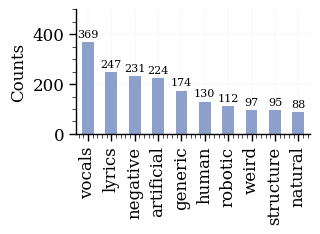

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2 * (1.61 * 2/3)))

import matplotlib

cmap = matplotlib.colormaps.get_cmap('Set2')


(m['value'].
 str.split('-', expand=True)[1].rename('Tag').
 value_counts().nlargest(10).plot.bar(ax=ax, color=cmap.colors[2])
)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=8, padding=2)
ax.set_ylim((0, 500))
ax.set_ylabel('Counts')
ax.set_xlabel(None)
sns.despine()

plt.savefig('tags.pdf',bbox_inches='tight')

fig.tight_layout(pad=0.0)

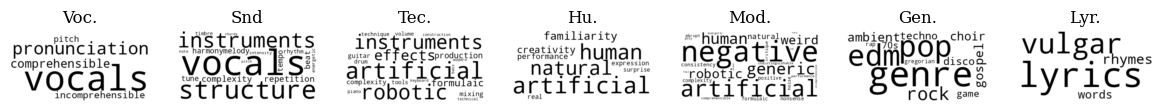

In [225]:
from wordcloud import WordCloud

cnts = m['value'].str.split('-', expand=True)[1].rename('Tag').value_counts()
cnts_dict = cnts.to_dict()

fig, axes = plt.subplots(1, 7, figsize=(12, 1.6 * (1.61 * 2/3)))

# ax = axes[0]
# cmap = matplotlib.colormaps.get_cmap('Set2')

# (cnts.
#  nlargest(5)[::-1].
#  plot.barh(ax=ax, color=cmap.colors[2])
# )

# for container in ax.containers:
#     ax.bar_label(container, fmt='%d', fontsize=8, padding=2)
# # ax.set_ylim((0, 500))
# # ax.set_xlabel('Counts')
# ax.set_ylabel(None)
# sns.despine()

for ax, (theme, words) in zip(axes, theme_mappings.items()):
    words = set(words)
    wc = WordCloud(
        background_color='white',
        relative_scaling=0.2,
        max_font_size=100,
        color_func=lambda *args, **kwargs: "black"
    ).fit_words({k:v for k, v in cnts_dict.items() if k in words})
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(theme)
    ax.axis("off")

# Hide any unused subplots
for ax in axes[len(theme_mappings):]:
    ax.axis("off")


fig.tight_layout(pad=2)

plt.savefig('wcs.pdf',bbox_inches='tight')

In [226]:
from scipy.stats import chi2_contingency

In [227]:
chose_a = df_answer[df_answer['human_perception'] == 1].merge(themes_count, on='id')  # a ai
chose_b = df_answer[df_answer['human_perception'] == 2].merge(themes_count, on='id')  # b ai


rq1 = df_answer[df_answer['track_A'].str.contains('rq1')].merge(themes_count, on='id')
rnd = df_answer[~df_answer['track_A'].str.contains('rq1')].merge(themes_count, on='id')

correct = df_answer_strd[
    (df_answer_strd['resp'] == 'a_ai') &
    (df_answer_strd['a_type'] == 'genai')
].merge(themes_count, on='id')
mistakes = df_answer_strd[
    ~((df_answer_strd['resp'] == 'a_ai') &
      (df_answer_strd['a_type'] == 'genai'))
].merge(themes_count, on='id')

A and B pval 0.4027864201593881
R and S pval 0.08002453285347869
M and C pval 0.0018039931104474453
M and C | Rnd pval 0.005351464105877496


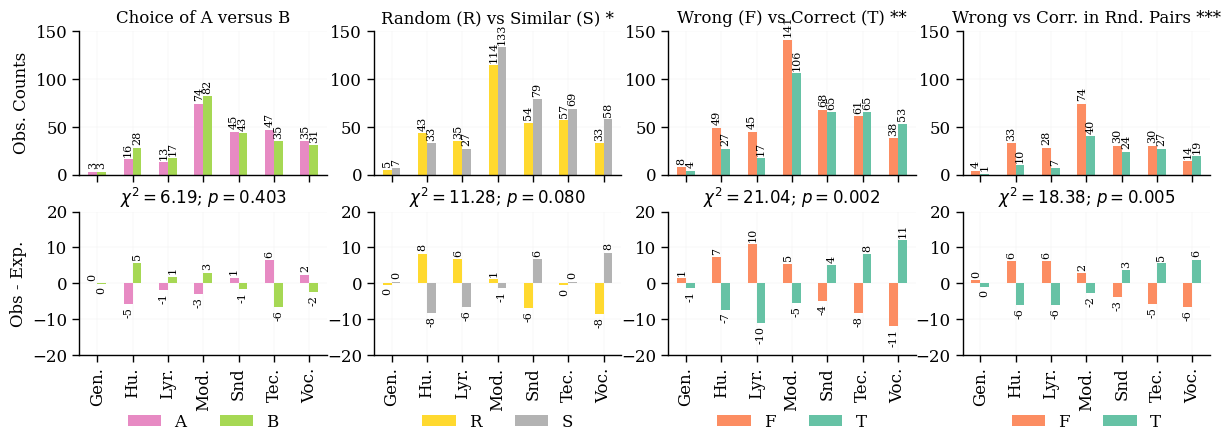

In [228]:
fig, ax = plt.subplots(2, 4, figsize=(12, 4 * (1.61 * 2/3)))
cmap = matplotlib.colormaps.get_cmap('Set2')


# (m['value'].
#  str.split('-', expand=True)[1].rename('Tag').
#  value_counts().nlargest(10).plot.bar(ax=ax[0], color=cmap.colors[2])
# )

bar1 = chose_a.groupby('theme').size()
bar2 = chose_b.groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['A', 'B']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 0], color=[cmap.colors[3], cmap.colors[4]])

csq = chi2_contingency(bars)
print('A and B pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(ax=ax[1, 0], color=[cmap.colors[3], cmap.colors[4]])
ax[1, 0].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')


bar1 = rnd.groupby('theme').size()
bar2 = rq1.groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['R', 'S']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 1], color=[cmap.colors[5], cmap.colors[7]])

csq = chi2_contingency(bars)
print('R and S pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(ax=ax[1, 1], color=[cmap.colors[5], cmap.colors[7]])
ax[1, 1].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')


bar1 = mistakes.groupby('theme').size()
bar2 = correct.groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['F', 'T']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 2], color=[cmap.colors[1], cmap.colors[0]])

csq = chi2_contingency(bars)
print('M and C pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(ax=ax[1, 2], color=[cmap.colors[1], cmap.colors[0]])
ax[1, 2].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')



idx_m_rnd = mistakes.track_A.str.contains('random')
idx_c_rnd = correct.track_A.str.contains('random')

bar1 = mistakes[idx_m_rnd].groupby('theme').size()
bar2 = correct[idx_c_rnd].groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['F', 'T']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 3], color=[cmap.colors[1], cmap.colors[0]])

csq = chi2_contingency(bars)
print('M and C | Rnd pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(ax=ax[1, 3], color=[cmap.colors[1], cmap.colors[0]])
ax[1, 3].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')


sns.despine()

for a in ax[0]:
    # a.yaxis.set_major_formatter(StrMethodFormatter('{x:,d}'))
    a.set_xlabel(None)
    a.set_ylim((0, 150))
    a.set_xticklabels([])
    a.minorticks_off()
    a.get_legend().remove()


for a in ax[1]:
    # a.yaxis.set_major_formatter(StrMethodFormatter('{x:,d}'))
    a.set_ylim((-20, 20))
    a.set_xlabel(None)
    a.get_legend().remove()
    a.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.3), frameon=False)
    a.minorticks_off()

for a in ax.ravel():
    for container in a.containers:
        a.bar_label(container, fmt='%d', rotation=90, fontsize=8, padding=2)
        
ax[1, 0].set_ylabel(r'Obs - Exp.')
ax[0, 0].set_ylabel('Obs. Counts')
ax[0, 0].set_title('Choice of A versus B')
ax[0, 1].set_title('Random (R) vs Similar (S) *')
ax[0, 2].set_title('Wrong (F) vs Correct (T) **')
ax[0, 3].set_title('Wrong vs Corr. in Rnd. Pairs ***')
fig.tight_layout(pad=0.0)
plt.savefig('themes.pdf',bbox_inches='tight')

## More complex plot of theme usage when believes is AI, regardless or right and wrong

In [231]:
p_cnts = theme_usage(p, keep_songs=True).groupby(['id', 'theme']).size().unstack(fill_value=0)
g_cnts = theme_usage(g, keep_songs=True).groupby(['id', 'theme']).size().unstack(fill_value=0)
h_cnts = theme_usage(h, keep_songs=True).groupby(['id', 'theme']).size().unstack(fill_value=0)

count_df = g_cnts + p_cnts + h_cnts

themes_count = count_df.reset_index().melt(id_vars='id')
themes_count = themes_count[themes_count['value'] == 3]
themes_count

,id,theme,value
47,29d12a93-6563-44e4-bfe5-787e86f3f5b1,song_a-Gen.,3.0
168,890cb4fb-fac2-493c-a7a6-8c6dc9597b6c,song_a-Gen.,3.0
182,947613e2-e674-47b7-87b2-5fd8f5b63c3d,song_a-Gen.,3.0
189,96919f14-5fa2-4b19-8c6a-e71d7354446d,song_a-Gen.,3.0
260,cbbe0dbd-5b53-40d1-aeb9-caf988817810,song_a-Gen.,3.0
...,...,...,...
6621,cbcef4cc-5adb-4c66-934a-6f3e1f79ead8,song_overall-Voc.,3.0
6633,d6edbc9b-64d7-4224-a7ba-523f4c0d46ae,song_overall-Voc.,3.0
6643,e3631cd5-689d-4ece-b9aa-dfdd44a9ecea,song_overall-Voc.,3.0
6673,f725c820-6230-405b-891a-1befe9def498,song_overall-Voc.,3.0


In [235]:
believes_a = df_answer_strd[
    df_answer_strd['resp'] == 'a_ai'
].merge(
    themes_count[
        themes_count['theme'].str.contains('song_a')
    ], 
    on='id'
)

believes_b = df_answer_strd[
    df_answer_strd['resp'] == 'b_ai'
].merge(
    themes_count[
        themes_count['theme'].str.contains('song_b')
    ], 
    on='id'
)


human_a = df_answer_strd[
    df_answer_strd['resp'] == 'b_ai'
].merge(
    themes_count[
        themes_count['theme'].str.contains('song_a')
    ], 
    on='id'
)

human_b = df_answer_strd[
    df_answer_strd['resp'] == 'a_ai'
].merge(
    themes_count[
        themes_count['theme'].str.contains('song_b')
    ], 
    on='id'
)

believes_ai = pd.concat((believes_a, believes_b))
believes_human = pd.concat((human_a, human_b))


believes_ai['theme'] = (
    believes_ai['theme'].
    str.replace('song_a-', '').
    str.replace('song_b-', '')
)
believes_human['theme'] = (
    believes_human['theme'].
    str.replace('song_a-', '').
    str.replace('song_b-', '')
)

AI and H pval 0.979638122832884


<Axes: xlabel='Topic'>

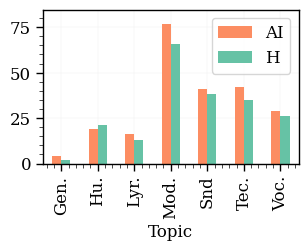

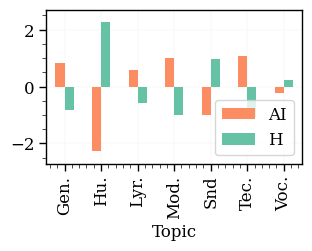

In [236]:
bar1 = believes_ai.groupby('theme').size()
bar2 = believes_human.groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['AI', 'H']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(color=[cmap.colors[1], cmap.colors[0]])

csq = chi2_contingency(bars)
print('AI and H pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(color=[cmap.colors[1], cmap.colors[0]])

A and B pval 0.4027864201593881
AI and H pval 0.979638122832884
             AI         H
Topic                    
Gen.   0.811189 -0.811189
Hu.   -2.258741  2.258741
Lyr.   0.587413 -0.587413
Mod.   1.000000 -1.000000
Snd   -0.986014  0.986014
Tec.   1.076923 -1.076923
Voc.  -0.230769  0.230769
M and C pval 0.0018039931104474453
M and C | Rnd pval 0.005351464105877496


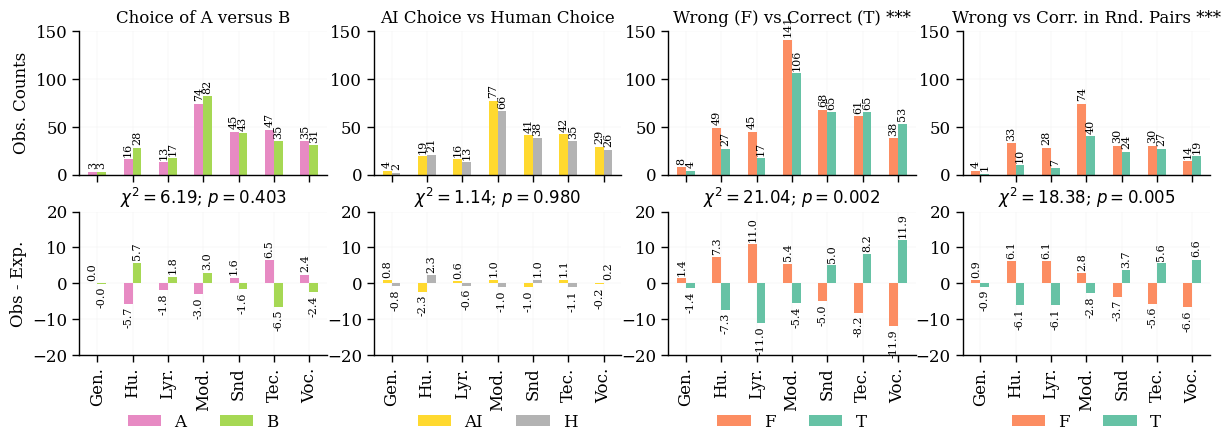

In [241]:
fig, ax = plt.subplots(2, 4, figsize=(12, 4 * (1.61 * 2/3)))
cmap = matplotlib.colormaps.get_cmap('Set2')


# (m['value'].
#  str.split('-', expand=True)[1].rename('Tag').
#  value_counts().nlargest(10).plot.bar(ax=ax[0], color=cmap.colors[2])
# )

bar1 = chose_a.groupby('theme').size()
bar2 = chose_b.groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['A', 'B']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 0], color=[cmap.colors[3], cmap.colors[4]])

csq = chi2_contingency(bars)
print('A and B pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(ax=ax[1, 0], color=[cmap.colors[3], cmap.colors[4]])
ax[1, 0].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')


bar1 = believes_ai.groupby('theme').size()
bar2 = believes_human.groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['AI', 'H']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 1], color=[cmap.colors[5], cmap.colors[7]])

csq = chi2_contingency(bars)
print('AI and H pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
print((bars - exp))
(bars - exp).plot.bar(ax=ax[1, 1], color=[cmap.colors[5], cmap.colors[7]])
ax[1, 1].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')


bar1 = mistakes.groupby('theme').size()
bar2 = correct.groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['F', 'T']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 2], color=[cmap.colors[1], cmap.colors[0]])

csq = chi2_contingency(bars)
print('M and C pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(ax=ax[1, 2], color=[cmap.colors[1], cmap.colors[0]])
ax[1, 2].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')



idx_m_rnd = mistakes.track_A.str.contains('random')
idx_c_rnd = correct.track_A.str.contains('random')

bar1 = mistakes[idx_m_rnd].groupby('theme').size()
bar2 = correct[idx_c_rnd].groupby('theme').size()
bars = pd.concat((bar1, bar2), axis='columns')
bars.columns = ['F', 'T']
bars_p = bars / bars.sum()
bars_p.index.names = ['Topic']
bars.plot.bar(ax=ax[0, 3], color=[cmap.colors[1], cmap.colors[0]])

csq = chi2_contingency(bars)
print('M and C | Rnd pval', csq.pvalue)
exp = pd.DataFrame(csq.expected_freq, columns=bars.columns, index=bars.index)
# exp = exp / exp.sum()
(bars - exp).plot.bar(ax=ax[1, 3], color=[cmap.colors[1], cmap.colors[0]])
ax[1, 3].set_title(rf'$\chi^2={csq.statistic:.2f}$; $p={csq.pvalue:.3f}$')


sns.despine()

for a in ax[0]:
    # a.yaxis.set_major_formatter(StrMethodFormatter('{x:,d}'))
    a.set_xlabel(None)
    a.set_ylim((0, 150))
    a.set_xticklabels([])
    a.minorticks_off()
    a.get_legend().remove()
    for container in a.containers:
        a.bar_label(container, fmt='%d', rotation=90, fontsize=8, padding=2)

for a in ax[1]:
    # a.yaxis.set_major_formatter(StrMethodFormatter('{x:,d}'))
    a.set_ylim((-20, 20))
    a.set_xlabel(None)
    a.get_legend().remove()
    a.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.3), frameon=False)
    a.minorticks_off()

    for container in a.containers:
        a.bar_label(container, fmt='%.1f', rotation=90, fontsize=8, padding=2)
        
ax[1, 0].set_ylabel(r'Obs - Exp.')
ax[0, 0].set_ylabel('Obs. Counts')
ax[0, 0].set_title('Choice of A versus B')
ax[0, 1].set_title('AI Choice vs Human Choice')
ax[0, 2].set_title('Wrong (F) vs Correct (T) ***')
ax[0, 3].set_title('Wrong vs Corr. in Rnd. Pairs ***')
fig.tight_layout(pad=0.0)
plt.savefig('themes-2.pdf',bbox_inches='tight')

In [43]:
import nltk

from nltk.metrics import agreement
from nltk.metrics.agreement import AnnotationTask
from nltk.metrics import masi_distance

In [44]:
raters = [
        ('coder1', theme_usage(g)),
        ('coder2', theme_usage(p)),
        ('coder3', theme_usage(h))
    ]
    
task_data = []

for coder, df in raters:
    # Group by item id and collect tags into a frozenset
    grouped = df.groupby('id')['theme'].apply(lambda x: frozenset(x)).reset_index()

    # Build (coder, item_id, frozenset(tags)) tuples
    for _, row in grouped.iterrows():
        task_data.append((coder, row['id'], row['theme']))


task = AnnotationTask(distance = masi_distance)
task.load_array(task_data)
task.alpha()

0.5495440237947393